In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import cPickle as pickle
import codecs
import skfuzzy as fuzz 
import time
import h5py
import subprocess

from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import metrics
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from sklearn.cluster.bicluster import SpectralCoclustering
from biclustering.biclustering import DeltaBiclustering
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score

In [291]:
%matplotlib inline
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (16, 8)})
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.max_rows', 1000000)

In [292]:
np.set_printoptions(precision=5)

In [4]:
arena_news_df = pd.read_pickle('arena_news_df.pkl')
sport_news_df = pd.read_pickle('sport_news_df.pkl')
jovem_news_df = pd.read_pickle('jovem_news_df.pkl')

In [120]:
arena_news_df.ix[0:99]

,url,title,description,body,all
0,http://arena.ig.com.br/2014-10-09/os-campeonatos-da-brasil-game-show.html,Os campeonatos da 'Brasil Game Show',Confira os campeonatos que rolam no evento,"O ""Brasil Game Show"" acontece de 09 até 12/10 - no dia 08 abre apenas para imprensa - no Expo Center Norte em São Paulo. Não será vendido ingresso no local, para comprar acesse o site da BGS . A BGS é a maior feira de jogos eletrônicos da América Latina, conta com a presença das maiores empresas de games do mundo. Com mais de 180 empresas, a feira tornou-se um dos principais eventos do segmento. O Evento foi escolhido pelos desenvolvedores, produtoras e distribuidoras para apresentar...",campeonatos brasil game show confira campeonatos rolam evento brasil game show acontece dia abre apenas imprensa expo center norte paulo vendido ingresso local comprar acesse site bgs bgs maior feira jogos eletrônicos américa latina conta presença maiores empresas games mundo empresas feira tornou principais eventos segmento evento escolhido desenvolvedores produtoras distribuidoras apresentar público principais jogos lançamentos ano incluindo realização coletivas campeonatos edição evento p...
1,http://arena.ig.com.br/2014-09-09/conheca-o-jogo-usado-para-lancar-o-iphone-6.html,Conheça o jogo usado para lançar o iPhone 6,"Vainglory é um multiplayer de batalha, no estilo League of Legends","\n\t \n\t \t\t\t\t\n\t\t Divulgação \n\t\t Desenvolvedor mostrou efeitos de luz do game, rodando a maior resolução em um iPhone 6 \n\t \n A empresa decidiu apresentar o game Vainglory no evento de lançamento do iPhone 6 (e a versão Metal). Tudo como pano de fundo para enaltecer as qualidades gráficas e a API gráfica do iOS 8 do novo device. O jogo foi desenvolvido pela Super Evil Megacorp, para iOS. É o primeiro game do estúdio, mas parece que os caras são super bem assessorados. O chefe de ...",conheça jogo usado lançar iphone vainglory multiplayer batalha estilo league of legends desenvolvedor mostrou efeitos luz game rodando maior resolução iphone empresa decidiu apresentar game vainglory evento lançamento iphone versão metal pano fundo enaltecer qualidades gráficas api gráfica ios novo device jogo desenvolvido super evil megacorp ios game estúdio parece caras super bem assessorados chefe operações nada menos kristian segerstrale ex diretor digital electronic arts bo daly ex rock...
2,http://arena.ig.com.br/2014-09-25/avaliacao-do-fifa-15-por-um-jogador-fanatico.html,Avaliação do FIFA 15 por um jogador fanático,Convidamos um jogador maníaco por FIFA para dizer quais são os pontos positivos e negativos do game,"Aspectos Positivos Estádios A novidade é que o FIFA 15 possui todos os 20 estádios da Premier League (Inglaterra), sendo 12 deles novos no game. O resto dos estádios são dos principais clubes como Real Madrid, Barcelona, Bayern de Munique, Juventus e PSG. Modo Carreira Os olheiros estão mais eficazes e identificam as áreas onde seu time precisa melhorar, os jogadores evoluem mais rápido. Também é possível criar varias escalações e salvá-las. Ultimate Team Novos jogadores legendas. (Apenas pa...",avaliação fifa jogador fanático convidamos jogador maníaco fifa dizer pontos positivos negativos game aspectos positivos estádios novidade fifa possui estádios premier league inglaterra novos game resto estádios principais clubes real madrid barcelona bayern munique juventus psg modo carreira olheiros eficazes identificam áreas onde time precisa melhorar jogadores evoluem rápido possível criar varias escalações salvá las ultimate team novos jogadores legendas apenas consoles microsoftagora p...
3,http://arena.ig.com.br/2014-09-11/paul-mccartney-escreveu-musica-para-destiny-sem-interesses-financeiros.html,Paul McCartney escreveu música para Destiny sem interesses financeiros,"Novo single “Hope for the Future” toca ao final do game, já quando os créditos sobem","\n\t \n\t \t\t\t\t\n\t\t Reprodução \n\t\t Paul aprovou! \n\t \n Não tinha “nenhum cheque envolvido, grande ou d

In [5]:
labels_true = np.array(len(arena_news_df.ix[0:99])*[0] + len(sport_news_df.ix[0:99])*[1] + len(jovem_news_df.ix[0:99])*[2])

In [6]:
count_vect = CountVectorizer(encoding='UTF-8',lowercase=False, min_df=2)
X = count_vect.fit_transform(arena_news_df['all'].ix[0:99].tolist() + sport_news_df['all'].ix[0:99].tolist() + jovem_news_df['all'].ix[0:99].tolist())

X_train_norm_tfidf = TfidfTransformer(norm=u'l2', use_idf=True).fit_transform(X).toarray()
X_train_tfidf = TfidfTransformer(norm=None, use_idf=True).fit_transform(X).toarray()
X_train_norm = TfidfTransformer(norm=u'l2', use_idf=False).fit_transform(X).toarray()
X_train = TfidfTransformer(norm=None, use_idf=False).fit_transform(X).toarray()

In [7]:
def to_csv(some_list, file_name, header):
    def to_str(st):
        if isinstance(st, str) or isinstance(st, unicode):
            return st
        else:
            return str(st)
    with codecs.open(file_name, 'w', 'utf-8') as file_stream:
        if len(header) != 0:
            file_stream.write(u','.join(header) + '\n')
        for item in some_list:
            if isinstance(item, tuple) or isinstance(item, list):
                line = u','.join(map(to_str, item)) + '\n'
            else:
                line = item + '\n'
            file_stream.write(line)
    file_stream.close()

In [8]:
def top_k(arr, k, axis=0):
    top_inds = np.argsort(arr, axis=axis)[-k:]
    top_vals = np.sort(arr, axis=axis)[-k:]
    return top_inds, top_vals

def reverse(arr):
    return arr[::-1]

def top_k_words_term_cluster(vec, X, count_vect, k):
    sum_per_word = np.sum(X, axis=0)
    top_inds, top_vals = top_k(vec, k)
    words = count_vect.get_feature_names()
    top_words = [words[i] for i in top_inds]
    correspondence_vals = [sum_per_word[i] for i in top_inds]

    top_pairs = reverse(zip(top_words, top_vals, correspondence_vals))

    return top_pairs

def top_k_words(vec, count_vect, k):
    top_inds, top_vals = top_k(vec, k)
    words = count_vect.get_feature_names()
    top_words = [words[i] for i in top_inds]
    top_pairs = reverse(zip(top_words, top_vals))
    return top_pairs

In [135]:
def run_algo(algo='onmtf'):
    error_best = np.inf

    if algo == 'onmtf':
        U = np.genfromtxt('/Users/lucasbrunialti/git/biclustering/experiments/U_max_ONMTF.csv', delimiter=',')
        S = np.genfromtxt('/Users/lucasbrunialti/git/biclustering/experiments/S_max_ONMTF.csv', delimiter=',')
        V = np.genfromtxt('/Users/lucasbrunialti/git/biclustering/experiments/V_max_ONMTF.csv', delimiter=',')
    elif algo == 'ovnmtf':
        U = np.genfromtxt('/Users/lucasbrunialti/git/biclustering/experiments/U_max_OvNMTF.csv', delimiter=',')
        S = np.genfromtxt('/Users/lucasbrunialti/git/biclustering/experiments/S_max_OvNMTF.csv', delimiter=',')
        hf = h5py.File('/Users/lucasbrunialti/git/biclustering/experiments/V_max_OvNMTF.hdf5','r')
        V = hf['dataset'][:]
    return U, S, V

## Top N words

In [10]:
sum_per_word = np.sum(X_train_tfidf, axis=0)
top_pairs = top_k_words(sum_per_word, count_vect, 100)
for word, value in top_pairs:
    sum_of_sums = np.sum(sum_per_word)
    rate = value / float(sum_of_sums)
    print '%s, %s' % (word, value)
#     print rate*100

jogos, 836.795899163
jogo, 763.655141479
games, 708.184193636
anos, 683.881935991
brasil, 651.601424416
skate, 621.51162202
monetáriointerno, 590.206797687
paulo, 496.294017008
gente, 489.339707604
minutos, 475.972573489
the, 467.995938055
of, 461.707554529
música, 450.551036311
game, 441.270256492
ano, 433.041877817
dia, 424.510073337
brasileiro, 408.80802506
melhor, 404.807874152
bem, 404.110139515
wii, 399.906006365
mundo, 397.478052102
pessoas, 395.104787197
vai, 388.288966223
mundial, 385.683658522
tempo, 385.486769128
segundo, 383.939034029
gol, 381.689968816
feira, 380.29140017
novo, 369.252844778
final, 366.772677234
time, 364.084526447
dois, 361.611244888
série, 359.070351576
jovem, 358.913169616
equipe, 354.961228704
casa, 353.247640217
xbox, 351.361160071
surfe, 350.018372784
conta, 344.112377251
título, 334.319435321
apenas, 334.121541208
playstation, 333.897201192
real, 333.212951915
temporada, 329.8202966
bola, 327.378810557
espanha, 319.827059275
barcelona, 317.849667625

## Top N words for channel

In [11]:
num_channels = 3
channels_names = ['arena', 'esporte', 'jovem']
for kk in range(num_channels):
    print '#########' + channels_names[kk]
    data = X.toarray()[100 * kk : 100*(kk + 1)]

    sum_per_word = np.sum(data, axis=0)
    top_pairs = top_k_words(sum_per_word, count_vect, 100)
    for word, value in top_pairs:
        sum_of_sums = np.sum(sum_per_word)
        rate = value / float(sum_of_sums)
#         print '%s, %s, %s' % (word, value, rate*100)
        print rate*100
    print '\n'

#########arena
1.62622349103
1.42230831974
0.881933115824
0.739192495922
0.723898858075
0.570962479608
0.545473083197
0.525081566069
0.509787928222
0.509787928222
0.443515497553
0.392536704731
0.387438825449
0.36704730832
0.356851549755
0.351753670473
0.336460032626
0.336460032626
0.316068515498
0.300774877651
0.300774877651
0.295676998369
0.285481239804
0.280383360522
0.270187601958
0.244698205546
0.244698205546
0.244698205546
0.244698205546
0.239600326264
0.234502446982
0.234502446982
0.234502446982
0.2294045677
0.224306688418
0.224306688418
0.224306688418
0.224306688418
0.224306688418
0.219208809135
0.214110929853
0.209013050571
0.203915171289
0.203915171289
0.198817292007
0.198817292007
0.193719412724
0.193719412724
0.188621533442
0.188621533442
0.188621533442
0.188621533442
0.188621533442
0.18352365416
0.18352365416
0.18352365416
0.18352365416
0.178425774878
0.178425774878
0.178425774878
0.178425774878
0.178425774878
0.178425774878
0.173327895595
0.173327895595
0.168230016313
0.16

## ONMTF, TF-IDF norm, k=3, l=5

In [316]:
k = 3
l = 5
n, m = X_train_norm_tfidf.shape
U, S, V = run_algo()

In [317]:
V.shape

(6764, 5)

In [318]:
labels_pred = np.argmax(U, axis=1)
adjusted_rand_score(labels_true, labels_pred)

0.7884852953432789

In [299]:
def search_peaks(A, eps=0.1):
    peaks_found = {}
    n, max_peaks = A.shape

    peaks = [1.0 / px for px in xrange(1, max_peaks+1)]

    for i in xrange(n):
        for peak_num, peak_value in enumerate(peaks):
            maybe_peaks = np.where((A[i, :] >= peak_value - eps) & (A[i, :] <= peak_value + eps))[0]
            if len(maybe_peaks) == peak_num + 1:
                if peak_num+1 in peaks_found:
                    peaks_found[peak_num+1].append(i)
                else:
                    peaks_found[peak_num+1] = [i]
    return peaks_found

In [300]:
# V / np.tile(np.sum(V, axis=1).T, (l, 1)).T
Vn = V / np.tile(np.sum(V, axis=1), (l, 1)).T
peaks = search_peaks(Vn)

In [301]:
# PEAKS ANALYSIS
peaks_dfs = {}
for peak_num in peaks.keys():
#     print
#     print '# %s-peak words' % peak_num
    peaks_dfs[peak_num] = []
    for w_id in peaks[peak_num]:
        word = count_vect.get_feature_names()[w_id]
#         print 'w: %s - tc: %s - vp: %s' % (word, Vn[w_id, :].argmax(), Vn[w_id, :])
        tempor = [word]
        tempor.extend(Vn[w_id, :].tolist())
        peaks_dfs[peak_num].append(tempor)
    peaks_dfs[peak_num] = pd.DataFrame(peaks_dfs[peak_num])

In [315]:
peaks_dfs[3].sort([5,], ascending=False)

,0,1,2,3,4,5
23,dedicando,2.371396e-01,3.196972e-36,3.345850e-01,0.000000,4.282754e-01
26,disputou,2.549259e-01,2.694390e-31,3.224544e-01,0.000000,4.226197e-01
68,quinze,2.697979e-01,3.118335e-01,1.729284e-43,0.000000,4.183686e-01
85,veterano,2.553989e-01,3.378290e-01,6.940820e-54,0.000000,4.067721e-01
66,quadra,2.787430e-01,3.225866e-01,2.055146e-25,0.000000,3.986704e-01
40,hotel,3.480605e-01,2.610018e-01,3.616477e-07,0.000000,3.909374e-01
31,especialmente,3.603602e-01,2.527249e-01,8.451170e-05,0.000000,3.868303e-01
6,batista,3.442370e-01,2.724804e-01,6.995802e-18,0.000000,3.832826e-01
62,preocupado,3.394790e-01,2.914082e-01,3.462450e-24,0.000000,3.691128e-01
35,federação,2.970783e-01,3.918770e-01,5.891937e-32,0.000000,3.110447e-01


In [211]:
labels_pred

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2,
       2, 2, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2])

In [225]:
words_per_cluster = {}
for ll in xrange(l):
    top_pairs = top_k_words_term_cluster(V[:, ll], X_train_norm_tfidf, count_vect, 200)
    print 'Cluster de termos %s' % ll
    ws = []
    values = []
    for w, v_value, tf_value in top_pairs[0:200]:
        ws.append(w)
        values.append(v_value)
    values = np.array(values) 
    values = values / values.sum()
    for w in np.random.choice(ws, 20, p=values, replace=False):
        print w
    print '\n'

#     aux = [ [w] * int((v_value / np.sum(Vn[:, ll])) * 10000) for w, v_value, _ in top_pairs[0:200]]  
    aux = [ [w] * int(v_value * 10000) for w, v_value, _ in top_pairs[0:200]]
    words_per_cluster[ll] = [item for sublist in aux for item in sublist]

Cluster de termos 0
burnquist
bob
bmx
circuito
prova
wt
medina
alejo
douglas
manobras
skate
mick
pistas
moto
resultado
red
slater
pontos
tempo
andando


Cluster de termos 1
inglês
árbitros
torcida
milhões
cavaliers
real
santos
seleção
tabela
saiu
clubes
jogar
equipes
final
bola
árbitro
ficar
maior
afirmou
deixar


Cluster de termos 2
ficou
contou
bob
lugar
venceu
atleta
começou
acho
bastos
ponta
joel
pupo
banda
vou
jovem
agosto
quartas
conta
brasil
mãe


Cluster de termos 3
tv
playstation
detalhes
live
league
papo
legends
corraini
nintendo
stanley
latina
xbox
sonic
onde
in
videogames
empresa
sociais
afirmou
desenvolvedores


Cluster de termos 4
gol
empate
vicente
atlético
euro
goleiro
liverpool
bayern
guardiola
xavi
coritiba
cristiano
itália
munique
grená
eliminatórias
bosque
derrotou
benzema
técnico




In [258]:
words_per_cluster = {}
words_for_cluster = np.array([np.argmax(V[j, :]) for j in xrange(m)])
for ll in xrange(l):
    print 'Cluster de termos %s' % ll
    words_for_cluster_ll = np.where(words_for_cluster == ll)[0]
    
#     ws = []
#     v_vals = []
#     for ind in words_for_cluster_ll:
#         w = count_vect.get_feature_names()[ind]
#         ws.append(w)
#         v_val = V[ind, ll]
#         v_vals.append(v_val)

#     v_vals = np.array(v_vals)
#     p = v_vals / v_vals.sum()
#     for w in np.random.choice(ws, 20, p=p, replace=False):
#         print w
#     print

    tup = []
    for ind in words_for_cluster_ll:
        w = count_vect.get_feature_names()[ind]
        v_val = V[ind, ll]
        tup.append((w, v_val))

    top_pairs = sorted(tup, key=lambda k: k[1], reverse=True)[0:200]
    
    for w, _ in top_pairs[0:20]:
        print w
    print

#     v_vals = np.array([val for _, val in top_pairs])
#     ws = [w for w, _ in top_pairs]
#     p = v_vals / v_vals.sum()
#     for w in np.random.choice(ws, 20, p=p, replace=False):
#         print w
#     print
        
#     for w, v_value, tf_value in top_pairs[0:200]:
#         print w, v_value
#     print
# #     aux = [ [w] * int((v_value / np.sum(Vn[:, ll])) * 10000) for w, v_value, _ in top_pairs[0:200]]  
#     aux = [ [w] * int(v_value * 10000) for w, v_value, _ in top_pairs[0:200]]
#     words_per_cluster[ll] = [item for sublist in aux for item in sublist]

Cluster de termos 0
skate
surfe
bob
burnquist
circuito
games
mineirinho
slater
rampa
medina
manobras
mega
megarampa
kelly
prova
bmx
pista
barros
skatistas
rony

Cluster de termos 1
real
breno
time
barcelona
partida
equipe
minutos
jogador
campeonato
liga
futebol
casa
temporada
grupo
feira
dois
vitória
tempo
área
copa

Cluster de termos 2
anos
mundial
brasil
etapa
brasileiro
jovem
rio
dias
música
pedro
atleta
americano
gente
esporte
campeão
competição
mundo
ano
janeiro
ufc

Cluster de termos 3
jogos
xbox
playstation
wii
jogo
of
console
sony
legends
nintendo
game
league
one
novo
ps
microsoft
the
usmonetáriointerno
controle
versão

Cluster de termos 4
gol
madrid
gols
messi
euro
guardiola
ronaldo
itália
cristiano
bola
bayern
pontos
espanhol
zagueiro
atacante
defesa
técnico
placar
atlético
polônia



In [163]:
# print S
print S / np.tile(np.sum(S, axis=1).T, (l, 1)).T

[[  0.00000e+000   5.18569e-001   8.27783e-002   4.81804e-003
    3.93835e-001]
 [  0.00000e+000   5.43778e-002   5.97195e-002   8.85903e-001
    0.00000e+000]
 [  4.39973e-001   3.05859e-002   5.29441e-001   3.15159e-125
    9.28843e-322]]


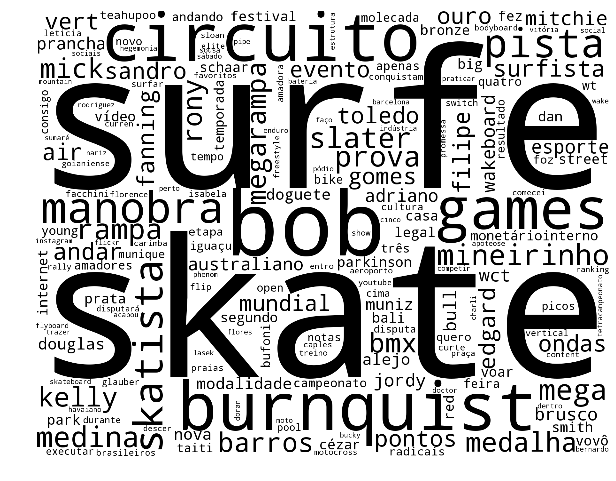

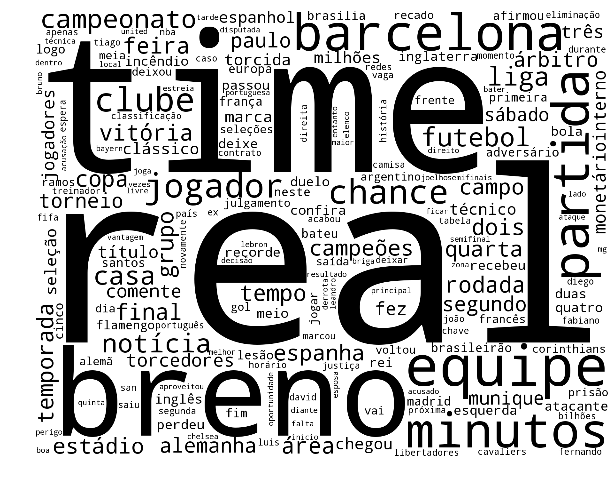

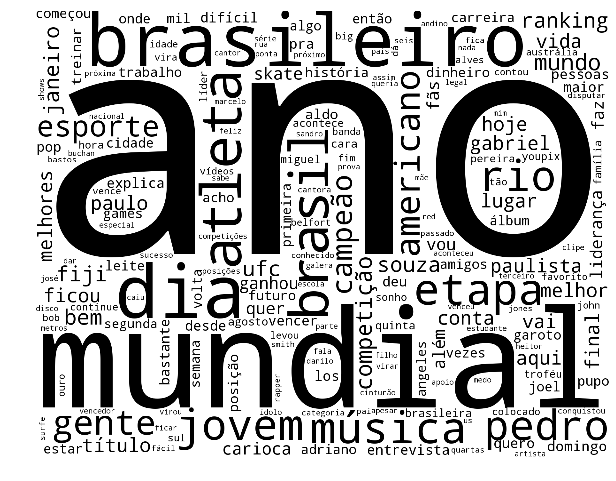

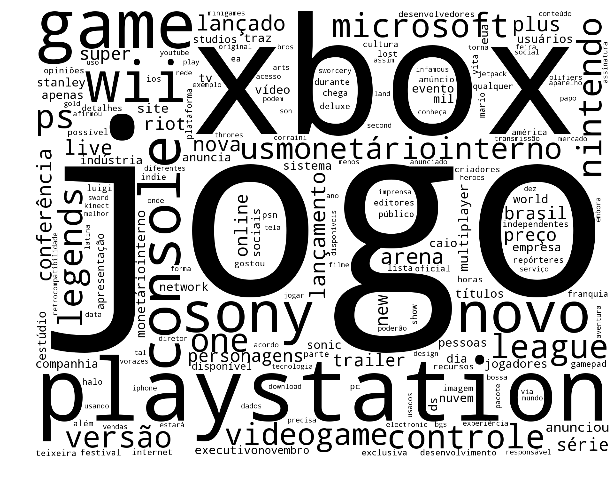

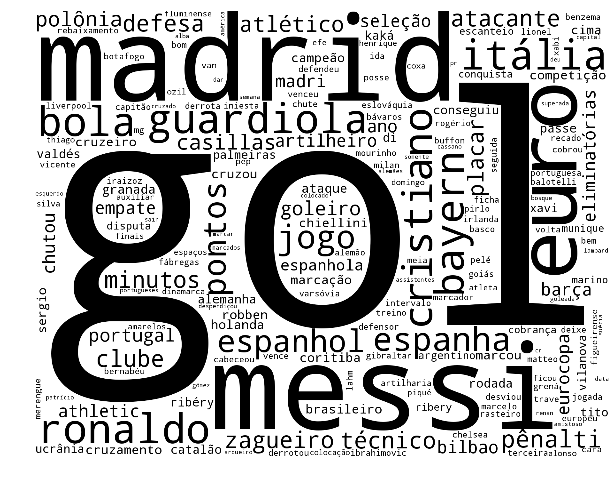

In [166]:
from wordcloud import WordCloud 

def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    return "hsl(%d, 0%%, 0%%)" % 1

for ll in xrange(l):
    wordcloud = WordCloud(background_color='white',
                          width=1800,
                          height=1400,
                          color_func=random_color_func
                         ).generate(' '.join(words_per_cluster[ll]))

    plt.imshow(wordcloud)
    plt.axis('off')
    plt.savefig('/Users/lucasbrunialti/git/masters-dissertation/img/onmtf-tc-%s.png' % (ll+1))
    plt.show()

In [320]:
print arena_news_df.ix[2]['url']
print
print arena_news_df.ix[2]['title']
print 
print arena_news_df.ix[2]['description']
print 
print arena_news_df.ix[2]['body']
print
print U[2, :]# / np.sum(U[2, :])

http://arena.ig.com.br/2014-09-25/avaliacao-do-fifa-15-por-um-jogador-fanatico.html

Avaliação do FIFA 15 por um jogador fanático

Convidamos um jogador maníaco por FIFA para dizer quais são os pontos positivos e negativos do game

Aspectos Positivos Estádios A novidade é que o FIFA 15 possui todos os 20 estádios da Premier League (Inglaterra), sendo 12 deles novos no game. O resto dos estádios são dos principais clubes como Real Madrid, Barcelona, Bayern de Munique, Juventus e PSG. Modo Carreira Os olheiros estão mais eficazes e identificam as áreas onde seu time precisa melhorar, os jogadores evoluem mais rápido. Também é possível criar varias escalações e salvá-las. Ultimate Team Novos jogadores legendas. (Apenas para os consoles da Microsoft)Agora tem como pegar jogadores por empréstimo. Uma maneira de resgatá-los é usando as moedas da EA. Gráficos Os rostos dos jogadores estão mais fiéis. O gramado se desgasta durante o desenrolar da partida, assim como os uniformes que vão ficand

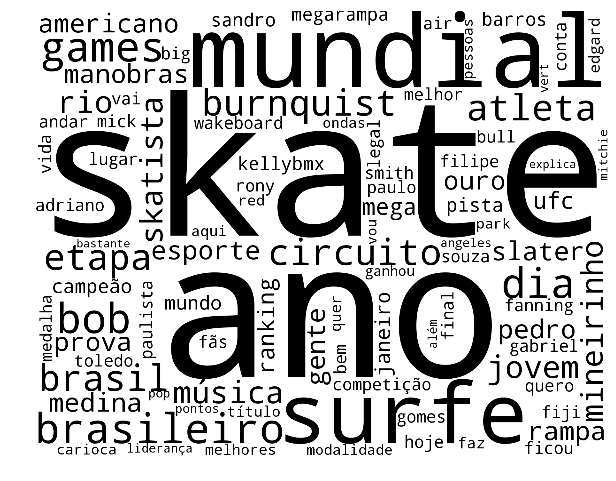

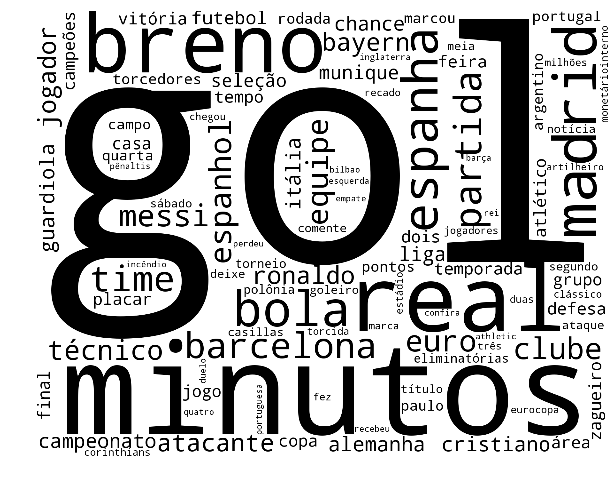

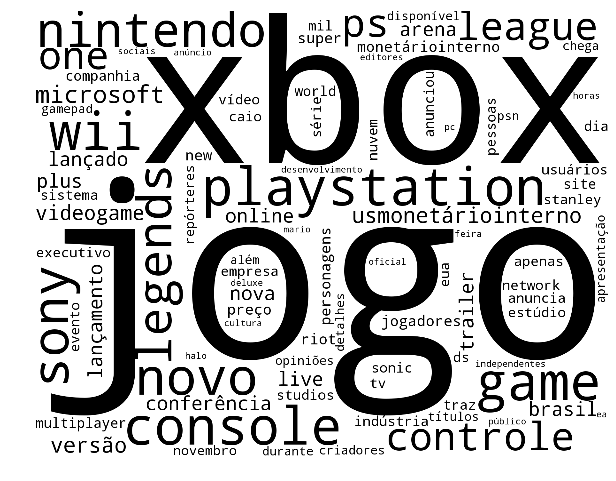

In [82]:
from wordcloud import WordCloud 

def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    return "hsl(%d, 0%%, 0%%)" % 1

for kk in xrange(k):
    wordcloud = WordCloud(background_color='white',
                          width=1800,
                          height=1400,
                          color_func=random_color_func
                         ).generate(' '.join(words_per_cluster[kk]))

    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

## OvNMTF, k=3, l=2, tf_norm

In [265]:
k = 3
l = 2
n, m = X_train_norm.shape
U, S, V = run_algo(algo='ovnmtf')

In [266]:
labels_pred = np.argmax(U, axis=1)
adjusted_rand_score(labels_true, labels_pred)

0.8304274320446424

In [267]:
S

array([[ 0.26886,  0.43521],
       [ 1.26628,  1.4984 ],
       [ 0.97873,  0.06461]])

In [268]:
S / np.tile( np.array([np.sum(S, axis=1)]).T, (1,l))

array([[ 0.38186,  0.61814],
       [ 0.45802,  0.54198],
       [ 0.93808,  0.06192]])

In [269]:
V[0].shape

(2, 6764)

In [270]:
Vn = []
for kk in xrange(k):
    Vnk = V[kk] / np.tile(np.sum(V[kk].T, axis=1), (l, 1))
    Vn.append(np.nan_to_num(Vnk))
Vn[0]

array([[ 0.38264,  0.     ,  0.78936, ...,  0.28292,  0.595  ,  0.64512],
       [ 0.61736,  0.     ,  0.21064, ...,  0.71708,  0.405  ,  0.35488]])

In [273]:
words_per_cluster = {}
for kk in xrange(k):
    words_per_cluster[kk] = {}
    words_for_cluster = np.array([np.argmax(V[kk].T[j, :]) for j in xrange(m)])
    for ll in xrange(l):
#         top_pairs = top_k_words_term_cluster(V[kk].T[:, ll], X_train_norm, count_vect, 200)
        print 'Cluster de termos %s' % ll
#         for w, v_value, tf_value in top_pairs[0:200]:
#             print w, v_value/ np.sum(V[kk].T[:, ll])
#         print '\n'
        words_for_cluster_ll = np.where(words_for_cluster == ll)[0]
        tup = []
        for ind in words_for_cluster_ll:
            w = count_vect.get_feature_names()[ind]
            v_val = V[kk].T[ind, ll]
            tup.append((w, v_val))

        top_pairs = sorted(tup, key=lambda k: k[1], reverse=True)[0:20]

        for w, _ in top_pairs[0:20]:
            print w
        print

#         aux = [ [w] * int((v_value / np.sum(V[kk].T[:, ll])) * 1000) for w, v_value, _ in top_pairs[0:200]]  
#         words_per_cluster[kk][ll] = [item for sublist in aux for item in sublist]

Cluster de termos 0
jogos
sony
ps
the
pessoas
wii
microsoft
nintendo
estúdio
one
arena
melhor
apenas
lançamento
versão
opiniões
caio
site
and
forma

Cluster de termos 1
jogo
of
playstation
game
novo
console
xbox
games
league
legends
brasil
além
nova
jogadores
dia
lançado
usmonetáriointerno
personagens
feira
dois

Cluster de termos 0
games
jovem
brasileiro
paulo
dia
mundo
ano
esporte
vai
janeiro
bem
burnquist
além
gente
bob
série
etapa
história
melhor
circuito

Cluster de termos 1
anos
skate
mundial
brasil
surfe
música
rio
conta
dias
primeira
final
atleta
pessoas
casa
paulista
ficou
fim
monetáriointerno
melhores
amigos

Cluster de termos 0
time
real
feira
final
gols
madrid
jogador
tempo
pontos
grupo
liga
fez
brasileiro
jogadores
campo
rodada
três
cristiano
copa
deixe

Cluster de termos 1
breno
casa
gol
bayern
minutos
clube
partida
técnico
título
livre
jogo
meia
volta
segunda
técnica
casillas
espanha
equipe
argentino
semana



News cocluster 0


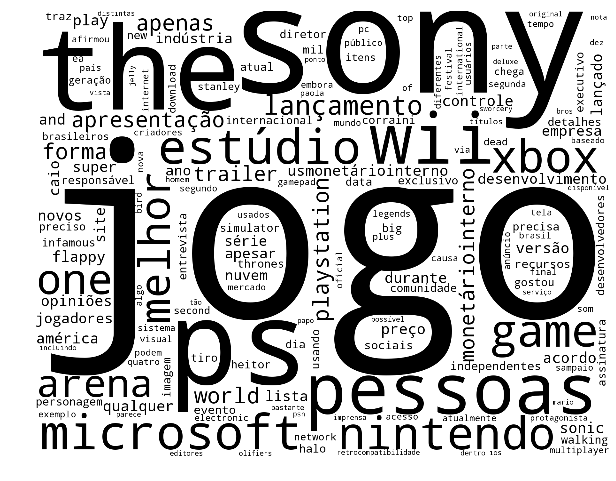

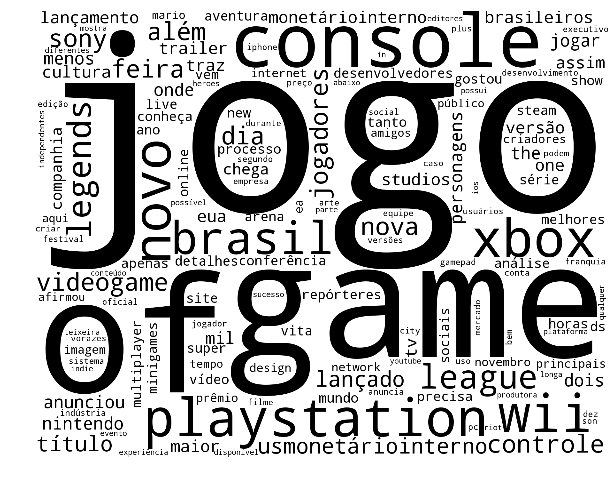

News cocluster 1


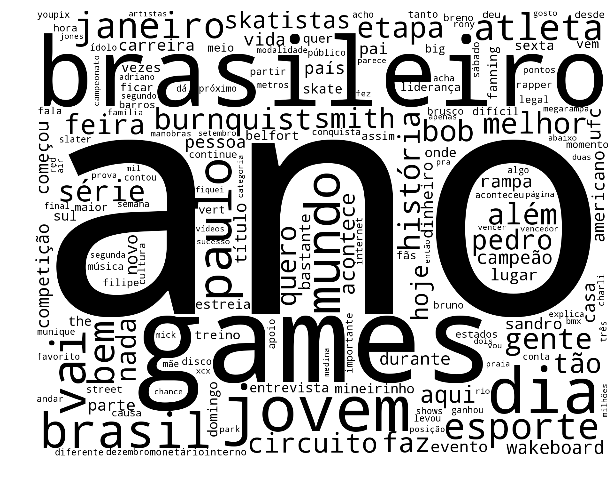

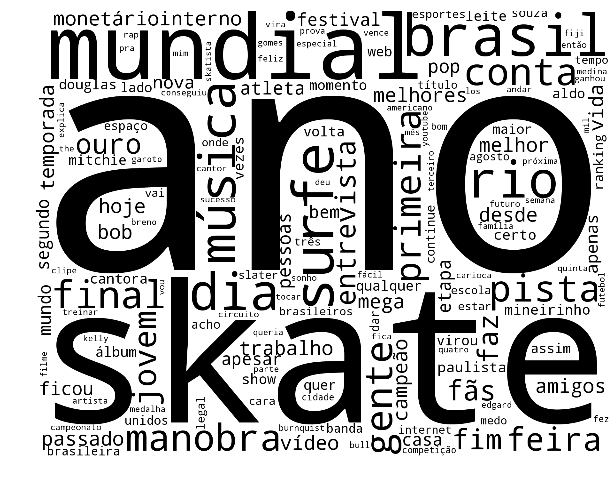

News cocluster 2


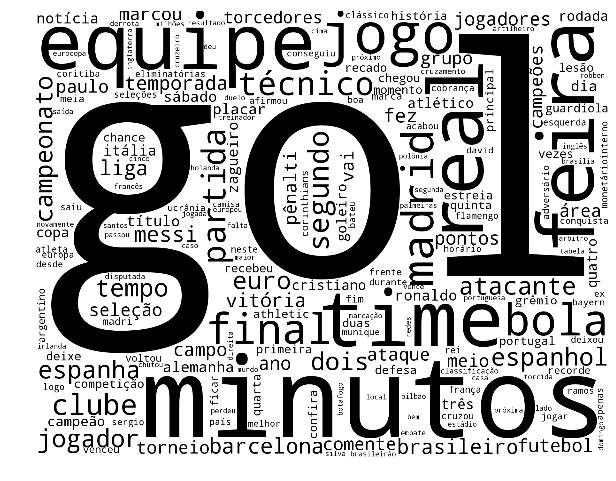

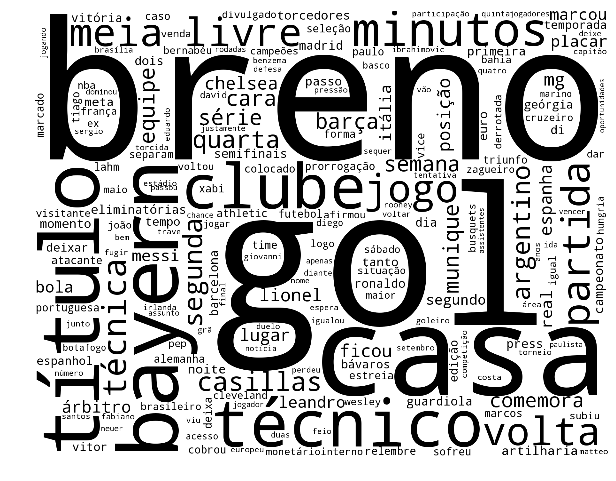

In [201]:
from wordcloud import WordCloud 

def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    return "hsl(%d, 0%%, 0%%)" % 1

for kk in xrange(k):
    print 'News cocluster %s' % kk
    for ll in xrange(l):
        wordcloud = WordCloud(background_color='white',
                              width=1800,
                              height=1400,
                              color_func=random_color_func,
                              stopwords=[]
                             ).generate(' '.join(words_per_cluster[kk][ll]))

        plt.imshow(wordcloud)
        plt.axis('off')
        plt.savefig('/Users/lucasbrunialti/git/masters-dissertation/img/ovnmtf-nc-%s-tc-%s.png' % (kk+1, ll+1))
        plt.show()